## Imports

In [1]:
!pip install efficientnet --upgrade -q
!pip install segmentation_models -q --upgrade

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
segmentation-models 1.0.1 requires efficientnet==1.0.0, but you have efficientnet 1.1.1 which is incompatible.


In [2]:
import os
import cv2
import glob
import shutil
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import segmentation_models as sm
import efficientnet.tfkeras as efn
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects

from tqdm.notebook import tqdm
from sklearn.model_selection import KFold

import warnings
warnings.simplefilter('ignore')

Segmentation Models: using `keras` framework.


## Config

In [3]:
sm.set_framework('tf.keras')
sm.framework()
os.environ['SM_FRAMEWORK'] = 'tf.keras'

class Config:
  
  gcs_path = 'gs://kds-a73771649e903d014193a8922ad9a9e622325a9f3af3c4949402f828'
  SEED = 1234

  AUTO = tf.data.experimental.AUTOTUNE

  n_folds = 5
  img_size = [256, 256]
  batch_size = 256

  backbone = 'efficientnetb0'
  epochs = 20
  lr = 1e-4

config = Config()

In [4]:
try: # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError: # no TPU found, detect GPUs
    #strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines
    strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    #strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy() # for clusters of multi-GPU machines

print("Number of accelerators: ", strategy.num_replicas_in_sync)

INFO:tensorflow:Initializing the TPU system: grpc://10.30.15.106:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.30.15.106:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Number of accelerators:  8


## GCS_PATHS

In [5]:
ALL_TRAINING_FILENAMES = tf.io.gfile.glob(config.gcs_path + '/train/*')
ALL_TRAINING_FILENAMES

['gs://kds-a73771649e903d014193a8922ad9a9e622325a9f3af3c4949402f828/train/0486052bb-355.tfrec',
 'gs://kds-a73771649e903d014193a8922ad9a9e622325a9f3af3c4949402f828/train/095bf7a1f-656.tfrec',
 'gs://kds-a73771649e903d014193a8922ad9a9e622325a9f3af3c4949402f828/train/1e2425f28-586.tfrec',
 'gs://kds-a73771649e903d014193a8922ad9a9e622325a9f3af3c4949402f828/train/26dc41664-794.tfrec',
 'gs://kds-a73771649e903d014193a8922ad9a9e622325a9f3af3c4949402f828/train/2f6ecfcdf-324.tfrec',
 'gs://kds-a73771649e903d014193a8922ad9a9e622325a9f3af3c4949402f828/train/4ef6695ce-1220.tfrec',
 'gs://kds-a73771649e903d014193a8922ad9a9e622325a9f3af3c4949402f828/train/54f2eec69-299.tfrec',
 'gs://kds-a73771649e903d014193a8922ad9a9e622325a9f3af3c4949402f828/train/8242609fa-770.tfrec',
 'gs://kds-a73771649e903d014193a8922ad9a9e622325a9f3af3c4949402f828/train/aaa6a05cc-134.tfrec',
 'gs://kds-a73771649e903d014193a8922ad9a9e622325a9f3af3c4949402f828/train/afa5e8098-1125.tfrec',
 'gs://kds-a73771649e903d014193a8922ad

In [6]:
import re
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)
print('NUM_TRAINING_IMAGES:' )
print(count_data_items(ALL_TRAINING_FILENAMES))

NUM_TRAINING_IMAGES:
9580


## Creating Folds

In [7]:
ALL_TRAINING_FILENAMES = np.array(ALL_TRAINING_FILENAMES)

splitter = KFold(n_splits=5, random_state=config.SEED)

train_files = []
valid_files = []

for fold, (trn_, val_) in enumerate(splitter.split(range(len(ALL_TRAINING_FILENAMES)))):
  fold_train_files = ALL_TRAINING_FILENAMES[trn_]
  fold_valid_files = ALL_TRAINING_FILENAMES[val_]
  np.random.shuffle(fold_train_files)
  train_files.append(fold_train_files)
  valid_files.append(fold_valid_files)

## Datasets pipeline

In [8]:
DIM = config.img_size[0]
def _parse_image_function(example_proto,augment = True):
    image_feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'mask': tf.io.FixedLenFeature([], tf.string)
    }
    single_example = tf.io.parse_single_example(example_proto, image_feature_description)
    image = tf.reshape(tf.io.decode_raw(single_example['image'],out_type=np.dtype('uint8')), (DIM,DIM, 3))
    mask =  tf.reshape(tf.io.decode_raw(single_example['mask'],out_type='bool'), (DIM,DIM,1))
    
    if augment:

        if tf.random.uniform(()) > 0.5:
            image = tf.image.flip_left_right(image)
            mask = tf.image.flip_left_right(mask)

        if tf.random.uniform(()) > 0.4:
            image = tf.image.flip_up_down(image)
            mask = tf.image.flip_up_down(mask)

        if tf.random.uniform(()) > 0.5:
            image = tf.image.rot90(image, k=1)
            mask = tf.image.rot90(mask, k=1)

        if tf.random.uniform(()) > 0.45:
            image = tf.image.random_saturation(image, 0.7, 1.3)

        if tf.random.uniform(()) > 0.45:
            image = tf.image.random_contrast(image, 0.8, 1.2)
    
    return tf.cast(image, tf.float32), tf.cast(mask, tf.float32)

def load_dataset(filenames, ordered=False, augment = True):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=config.AUTO)
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(lambda ex: _parse_image_function(ex, augment = augment), num_parallel_calls=config.AUTO)
    return dataset

def get_training_dataset(TRAINING_FILENAMES):
    dataset = load_dataset(TRAINING_FILENAMES)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(128, seed = config.SEED)
    dataset = dataset.batch(config.batch_size,drop_remainder=True)
    dataset = dataset.prefetch(config.AUTO)
    return dataset

def get_validation_dataset(VALIDATION_FILENAMES, ordered=True):
    dataset = load_dataset(VALIDATION_FILENAMES, ordered=ordered, augment = False)
    dataset = dataset.batch(config.batch_size,drop_remainder=True)
    dataset = dataset.prefetch(config.AUTO)
    return dataset

In [9]:
ds = get_training_dataset(train_files[0])

In [10]:
for i in ds:
  print(i[0].shape, i[1].shape)
  break

(256, 256, 256, 3) (256, 256, 256, 1)


## Metrics

In [11]:
# https://tensorlayer.readthedocs.io/en/latest/_modules/tensorlayer/cost.html#dice_coe
def dice_coe(output, target, axis = None, smooth=1e-10):
    output = tf.dtypes.cast( tf.math.greater(output, 0.5), tf. float32 )
    target = tf.dtypes.cast( tf.math.greater(target, 0.5), tf. float32 )
    inse = tf.reduce_sum(output * target, axis=axis)
    l = tf.reduce_sum(output, axis=axis)
    r = tf.reduce_sum(target, axis=axis)

    dice = (2. * inse + smooth) / (l + r + smooth)
    dice = tf.reduce_mean(dice, name='dice_coe')
    return dice

# https://www.kaggle.com/kool777/training-hubmap-eda-tf-keras-tpu
def tversky(y_true, y_pred, alpha=0.7, beta=0.3, smooth=1):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
    false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
    return (true_pos + smooth) / (true_pos + alpha * false_neg + beta * false_pos + smooth)
def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true, y_pred)
def focal_tversky_loss(y_true, y_pred, gamma=0.75):
    tv = tversky(y_true, y_pred)
    return K.pow((1 - tv), gamma)

get_custom_objects().update({"focal_tversky": focal_tversky_loss})

## Create Model

In [12]:
def get_model():
  model = sm.FPN(config.backbone, encoder_weights='imagenet', classes=1, activation='sigmoid')
  model.compile(optimizer = tf.keras.optimizers.Adam(lr = 0.00005),
                loss = sm.losses.bce_dice_loss,
                metrics=[dice_coe,'accuracy', sm.metrics.iou_score])
  return model

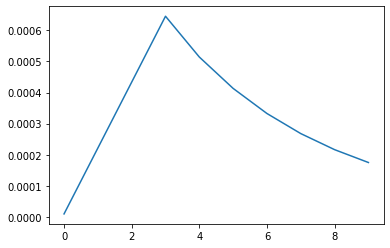

In [13]:
# Lr function
lr_start = 0.000005
lr_min = 0.00001
lr_max = 0.00000125 * 8 * 64
lr_decay = 0.8
lr_rampup = 3

def lrfn(epoch):
  if epoch <= lr_rampup:
    lr = (lr_max - lr_start)/lr_rampup * epoch + lr_min
  else:
    lr = (lr_max - lr_min) * lr_decay**(epoch - lr_rampup) + lr_min
  return lr

values = [lrfn(i) for i in range(10)]
plt.plot(values)

## Run Fold function

In [14]:
def run_fold(fold, display_plot=True):
  tfiles = train_files[fold]
  vfiles = valid_files[fold]

  K.clear_session()
  with strategy.scope():
    model = get_model()

  checkpoint = tf.keras.callbacks.ModelCheckpoint('./model-fold-%i.h5'%fold,
                                 monitor='val_dice_coe',patience = 10,
                                 mode='max',save_best_only=True)
  
  early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_dice_coe',mode = 'max', patience=10, restore_best_weights=True)

  lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=0)

  print(f'Training Model Fold {fold+1}...')
  history = model.fit(
      get_training_dataset(tfiles),
      epochs = config.epochs,
      steps_per_epoch = 9580//config.batch_size,
      callbacks = [checkpoint, lr_callback, early_stop],
      validation_data = get_validation_dataset(vfiles)
  )

  if display_plot:        
        plt.figure(figsize=(15,5))
        n_e = np.arange(len(history.history['dice_coe']))
        plt.plot(n_e,history.history['dice_coe'],'-o',label='Train dice_coe',color='#ff7f0e')
        plt.plot(n_e,history.history['val_dice_coe'],'-o',label='Val dice_coe',color='#1f77b4')
        x = np.argmax( history.history['val_dice_coe'] ); y = np.max( history.history['val_dice_coe'] )
        xdist = plt.xlim()[1] - plt.xlim()[0]; ydist = plt.ylim()[1] - plt.ylim()[0]
        plt.scatter(x,y,s=200,color='#1f77b4'); plt.text(x-0.03*xdist,y-0.13*ydist,'max dice_coe\n%.2f'%y,size=14)
        plt.ylabel('dice_coe',size=14); plt.xlabel('Epoch',size=14)
        plt.legend(loc=2)
        plt2 = plt.gca().twinx()
        plt2.plot(n_e,history.history['loss'],'-o',label='Train Loss',color='#2ca02c')
        plt2.plot(n_e,history.history['val_loss'],'-o',label='Val Loss',color='#d62728')
        x = np.argmin( history.history['val_loss'] ); y = np.min( history.history['val_loss'] )
        ydist = plt.ylim()[1] - plt.ylim()[0]
        plt.scatter(x,y,s=200,color='#d62728'); plt.text(x-0.03*xdist,y+0.05*ydist,'min loss',size=14)
        plt.ylabel('Loss',size=14)
        plt.legend(loc=3)
        plt.show()

  return history, model

## Training the model

Training Model Fold 1...
Epoch 1/20
37/37 [==============================] - 84s 738ms/step - loss: 1.4262 - dice_coe: 0.1725 - accuracy: 0.8170 - iou_score: 0.0451 - val_loss: 24.6518 - val_dice_coe: 0.0707 - val_accuracy: 0.0428 - val_iou_score: 0.0364
Epoch 2/20
37/37 [==============================] - 19s 508ms/step - loss: 0.6369 - dice_coe: 0.7398 - accuracy: 0.9813 - iou_score: 0.3285 - val_loss: 9.7287 - val_dice_coe: 0.2125 - val_accuracy: 0.7813 - val_iou_score: 0.1256
Epoch 3/20
37/37 [==============================] - 19s 509ms/step - loss: 0.2353 - dice_coe: 0.8621 - accuracy: 0.9926 - iou_score: 0.6673 - val_loss: 1.0449 - val_dice_coe: 0.5040 - val_accuracy: 0.9246 - val_iou_score: 0.3619
Epoch 4/20
37/37 [==============================] - 19s 503ms/step - loss: 0.1528 - dice_coe: 0.8936 - accuracy: 0.9943 - iou_score: 0.7748 - val_loss: 0.1919 - val_dice_coe: 0.8871 - val_accuracy: 0.9923 - val_iou_score: 0.7475
Epoch 5/20
37/37 [==============================] - 19s 50

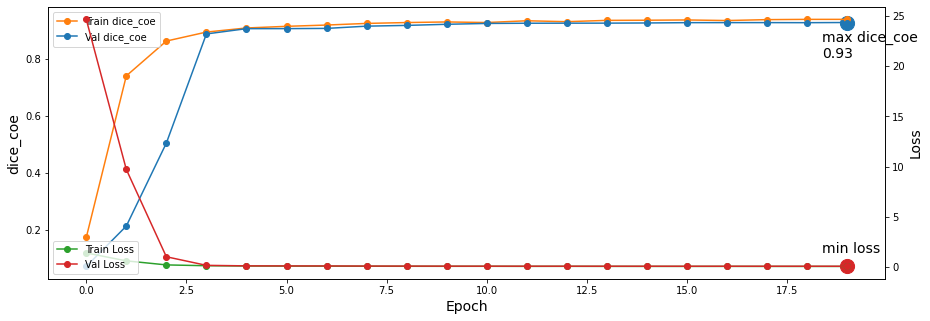

Training Model Fold 2...
Epoch 1/20
37/37 [==============================] - 85s 760ms/step - loss: 1.8876 - dice_coe: 0.0720 - accuracy: 0.2981 - iou_score: 0.0381 - val_loss: 8.1337 - val_dice_coe: 0.0563 - val_accuracy: 0.1733 - val_iou_score: 0.0288
Epoch 2/20
37/37 [==============================] - 19s 517ms/step - loss: 0.8189 - dice_coe: 0.6916 - accuracy: 0.9583 - iou_score: 0.2333 - val_loss: 7.4997 - val_dice_coe: 0.1126 - val_accuracy: 0.7061 - val_iou_score: 0.0602
Epoch 3/20
37/37 [==============================] - 19s 517ms/step - loss: 0.3253 - dice_coe: 0.8368 - accuracy: 0.9911 - iou_score: 0.5709 - val_loss: 1.8532 - val_dice_coe: 0.2517 - val_accuracy: 0.8499 - val_iou_score: 0.1499
Epoch 4/20
37/37 [==============================] - 19s 518ms/step - loss: 0.1961 - dice_coe: 0.8710 - accuracy: 0.9933 - iou_score: 0.7231 - val_loss: 0.2082 - val_dice_coe: 0.8591 - val_accuracy: 0.9922 - val_iou_score: 0.7204
Epoch 5/20
37/37 [==============================] - 19s 516

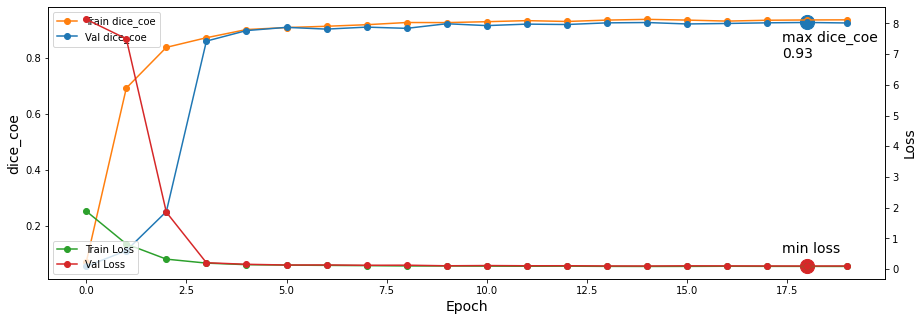

Training Model Fold 3...
Epoch 1/20
37/37 [==============================] - 83s 733ms/step - loss: 1.5135 - dice_coe: 0.1190 - accuracy: 0.7245 - iou_score: 0.0378 - val_loss: 14.4964 - val_dice_coe: 0.0767 - val_accuracy: 0.0470 - val_iou_score: 0.0391
Epoch 2/20
37/37 [==============================] - 18s 496ms/step - loss: 0.7096 - dice_coe: 0.7117 - accuracy: 0.9763 - iou_score: 0.2825 - val_loss: 7.0560 - val_dice_coe: 0.1418 - val_accuracy: 0.6973 - val_iou_score: 0.0758
Epoch 3/20
37/37 [==============================] - 18s 497ms/step - loss: 0.2350 - dice_coe: 0.8610 - accuracy: 0.9922 - iou_score: 0.6661 - val_loss: 1.3414 - val_dice_coe: 0.3634 - val_accuracy: 0.8810 - val_iou_score: 0.2339
Epoch 4/20
37/37 [==============================] - 18s 498ms/step - loss: 0.1648 - dice_coe: 0.8847 - accuracy: 0.9938 - iou_score: 0.7606 - val_loss: 0.2271 - val_dice_coe: 0.8706 - val_accuracy: 0.9910 - val_iou_score: 0.7104
Epoch 5/20
37/37 [==============================] - 18s 49

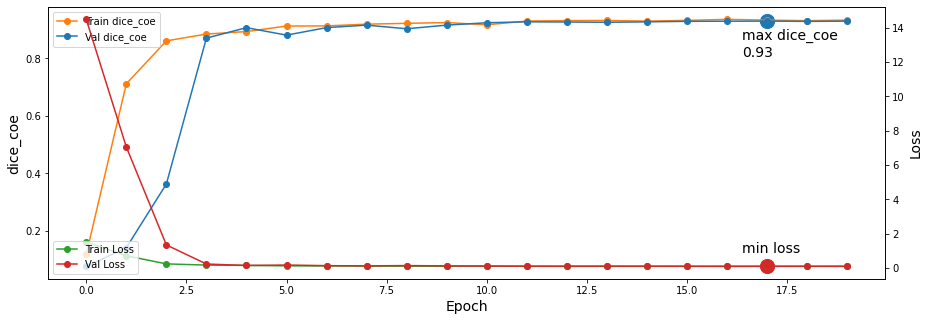

Training Model Fold 4...
Epoch 1/20
37/37 [==============================] - 85s 760ms/step - loss: 1.8150 - dice_coe: 0.0829 - accuracy: 0.3831 - iou_score: 0.0409 - val_loss: 31.0140 - val_dice_coe: 0.0531 - val_accuracy: 0.0348 - val_iou_score: 0.0277
Epoch 2/20
37/37 [==============================] - 19s 514ms/step - loss: 0.7540 - dice_coe: 0.7144 - accuracy: 0.9649 - iou_score: 0.2655 - val_loss: 3.9548 - val_dice_coe: 0.0927 - val_accuracy: 0.7397 - val_iou_score: 0.0458
Epoch 3/20
37/37 [==============================] - 19s 517ms/step - loss: 0.2835 - dice_coe: 0.8552 - accuracy: 0.9913 - iou_score: 0.6106 - val_loss: 1.0535 - val_dice_coe: 0.3952 - val_accuracy: 0.9206 - val_iou_score: 0.2063
Epoch 4/20
37/37 [==============================] - 19s 512ms/step - loss: 0.1744 - dice_coe: 0.8848 - accuracy: 0.9932 - iou_score: 0.7464 - val_loss: 0.3069 - val_dice_coe: 0.8180 - val_accuracy: 0.9932 - val_iou_score: 0.6041
Epoch 5/20
37/37 [==============================] - 19s 51

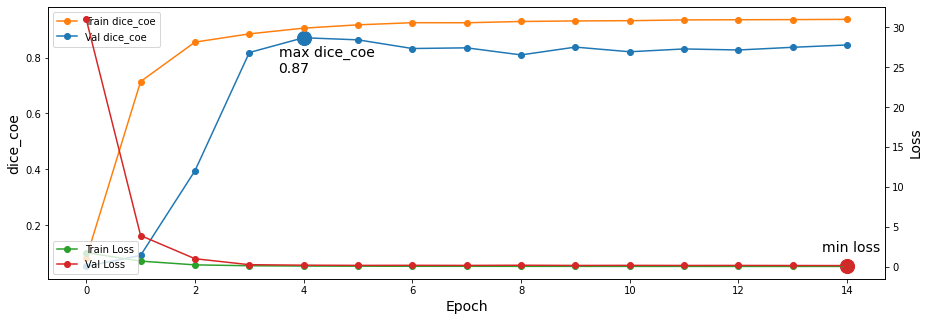

Training Model Fold 5...
Epoch 1/20
37/37 [==============================] - 83s 761ms/step - loss: 1.3506 - dice_coe: 0.2076 - accuracy: 0.8566 - iou_score: 0.0527 - val_loss: 18.9005 - val_dice_coe: 0.0430 - val_accuracy: 0.0460 - val_iou_score: 0.0220
Epoch 2/20
37/37 [==============================] - 19s 518ms/step - loss: 0.5610 - dice_coe: 0.7582 - accuracy: 0.9810 - iou_score: 0.3916 - val_loss: 17.3616 - val_dice_coe: 0.0612 - val_accuracy: 0.5520 - val_iou_score: 0.0313
Epoch 3/20
37/37 [==============================] - 19s 517ms/step - loss: 0.2062 - dice_coe: 0.8750 - accuracy: 0.9923 - iou_score: 0.7051 - val_loss: 1.2768 - val_dice_coe: 0.1947 - val_accuracy: 0.8949 - val_iou_score: 0.1124
Epoch 4/20
37/37 [==============================] - 19s 522ms/step - loss: 0.1399 - dice_coe: 0.9041 - accuracy: 0.9939 - iou_score: 0.7943 - val_loss: 0.3506 - val_dice_coe: 0.7330 - val_accuracy: 0.9921 - val_iou_score: 0.5724
Epoch 5/20
37/37 [==============================] - 19s 5

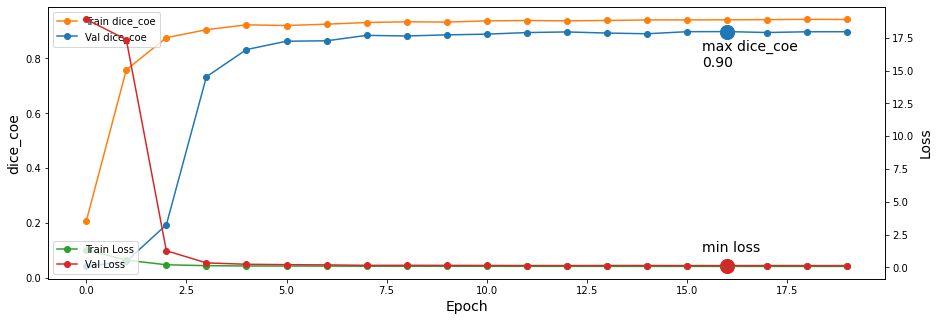

In [15]:
global_history = []

for fold in range(config.n_folds):
  history, _ = run_fold(fold)
  global_history.append(history)

In [16]:
avg_dice = 0
avg_loss = 0

for history in global_history:
  avg_dice += history.history['val_dice_coe'][-1]
  avg_loss += history.history['val_loss'][-1]

print('AVG Dice: ', avg_dice/config.n_folds)
print('AVG val loss: ', avg_loss/config.n_folds)

AVG Dice:  0.9044324517250061
AVG val loss:  0.12874505668878555
